In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Excel Dosyasını Yükle
# (Bu işlem dosya boyutuna göre biraz zaman alabilir)
print("Veri okunuyor, lütfen bekleyin...")
df = pd.read_excel('CovidDeaths.xlsx')

# 2. Tarih formatını garantiye alalım
df['date'] = pd.to_datetime(df['date'])

# 3. Eksik Sütunları Hesapla (Feature Engineering)
# Eğer bu sütunlar Excel'de zaten varsa üzerine yazarız, sorun olmaz.

# Milyon başına veriler
if 'total_cases' in df.columns and 'population' in df.columns:
    df['total_cases_per_million'] = (df['total_cases'] / df['population']) * 1_000_000
    df['total_deaths_per_million'] = (df['total_deaths'] / df['population']) * 1_000_000

# Aşılanma Oranı (Eğer aşı sütunu varsa)
if 'people_fully_vaccinated' in df.columns:
    df['vaccination_rate'] = (df['people_fully_vaccinated'] / df['population']) * 100

# Smoothed (Düzeltilmiş) Vaka (Grafiklerde dalgalanmayı önlemek için)
if 'new_cases' in df.columns:
    df['new_cases_smoothed'] = df.groupby('location')['new_cases'].transform(lambda x: x.rolling(window=7).mean())

# 4. Snapshot Al (Her ülkenin en güncel son durumu)
df_latest = df.sort_values('date').groupby('location').tail(1).copy()

# 5. CFR (Case Fatality Rate) Hesapla
df_latest['cfr'] = (df_latest['total_deaths'] / df_latest['total_cases']) * 100

# 6. df_filtered Tanımla (Hata veren değişken)
# Kurallar: CFR %10'dan küçük olsun, Nüfus 1 milyondan büyük olsun.
df_filtered = df_latest[
    (df_latest['cfr'] < 10) & 
    (df_latest['population'] > 1_000_000)
].copy()

print("✅ Kurulum tamamlandı! df, df_latest ve df_filtered hazır.")
print(f"Veri Seti Boyutu: {df.shape}")

Veri okunuyor, lütfen bekleyin...
✅ Kurulum tamamlandı! df, df_latest ve df_filtered hazır.
Veri Seti Boyutu: (85171, 60)


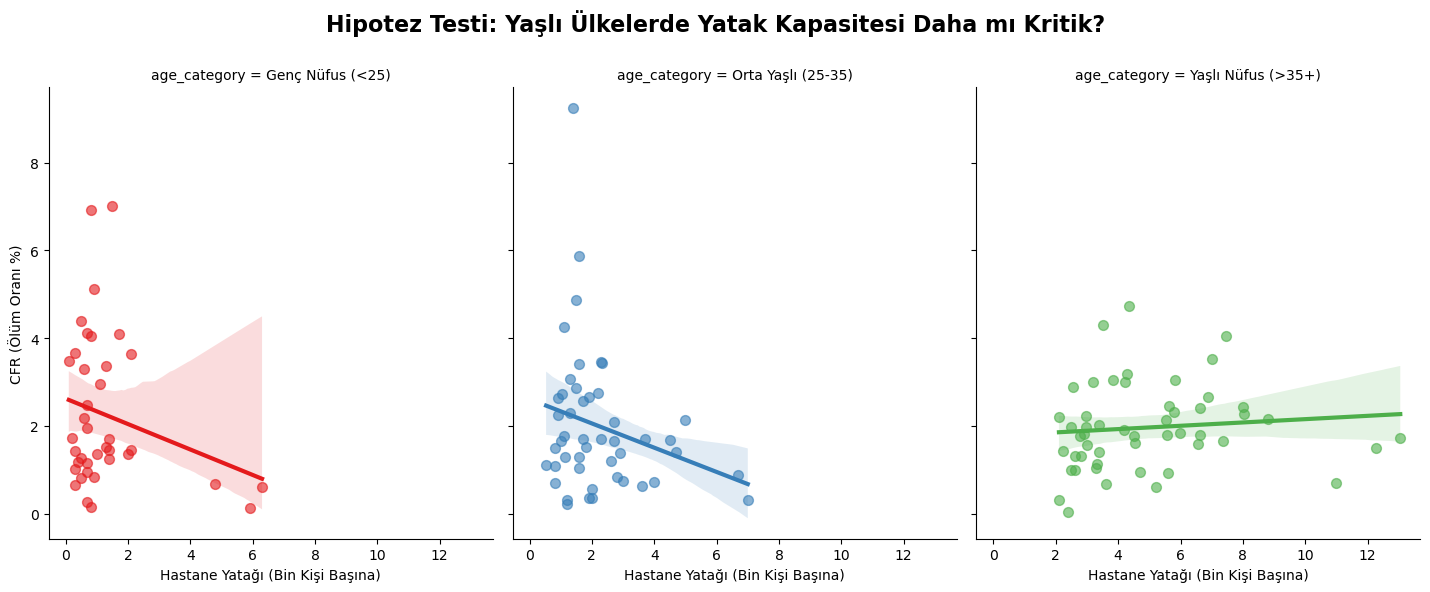

--- Yaş Gruplarına Göre Yatak Kapasitesinin Etkisi (Korelasyon) ---
Genç Nüfus (<25): Korelasyon = -0.24
   -> Veri Sayısı: 38 ülke
------------------------------
Orta Yaşlı (25-35): Korelasyon = -0.25
   -> Veri Sayısı: 47 ülke
------------------------------
Yaşlı Nüfus (>35+): Korelasyon = 0.10
   -> Veri Sayısı: 51 ülke
------------------------------


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veri Hazırlığı (Temiz ve güncel veri)
df_latest = df.sort_values('date').groupby('location').tail(1).copy()
df_latest['cfr'] = (df_latest['total_deaths'] / df_latest['total_cases']) * 100

# Veri temizliği (Outlier ve eksik verileri atalım)
df_sub = df_latest[
    (df_latest['cfr'] < 10) & 
    (df_latest['hospital_beds_per_thousand'] > 0) &
    (df_latest['population'] > 1_000_000)
].copy()

# 2. Ülkeleri Yaş Gruplarına Ayırma (Binning)
# Gruplar: Genç (<25), Orta (25-35), Yaşlı (>35)
bins = [0, 25, 35, 100]
labels = ['Genç Nüfus (<25)', 'Orta Yaşlı (25-35)', 'Yaşlı Nüfus (>35+)']

df_sub['age_category'] = pd.cut(df_sub['median_age'], bins=bins, labels=labels)

# 3. GRAFİK: FacetGrid ile Yan Yana 3 Grafik
# sns.lmplot bu iş için mükemmeldir, 'col' parametresiyle grafikleri yan yana dizer
g = sns.lmplot(
    data=df_sub,
    x='hospital_beds_per_thousand',
    y='cfr',
    col='age_category', # Sütunları yaş grubuna göre ayır
    hue='age_category', # Renkleri de ayır
    palette='Set1',
    height=6,
    aspect=0.8,
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'linewidth': 3}
)

# Başlık ve Düzenlemeler
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Hipotez Testi: Yaşlı Ülkelerde Yatak Kapasitesi Daha mı Kritik?', fontsize=16, fontweight='bold')
g.set_axis_labels("Hastane Yatağı (Bin Kişi Başına)", "CFR (Ölüm Oranı %)")

plt.show()

# 4. KORELASYON HESABI (Sayısal Kanıt)
print("--- Yaş Gruplarına Göre Yatak Kapasitesinin Etkisi (Korelasyon) ---")
for group in labels:
    subset = df_sub[df_sub['age_category'] == group]
    corr = subset['hospital_beds_per_thousand'].corr(subset['cfr'])
    print(f"{group}: Korelasyon = {corr:.2f}")
    print(f"   -> Veri Sayısı: {len(subset)} ülke")
    print("-" * 30)

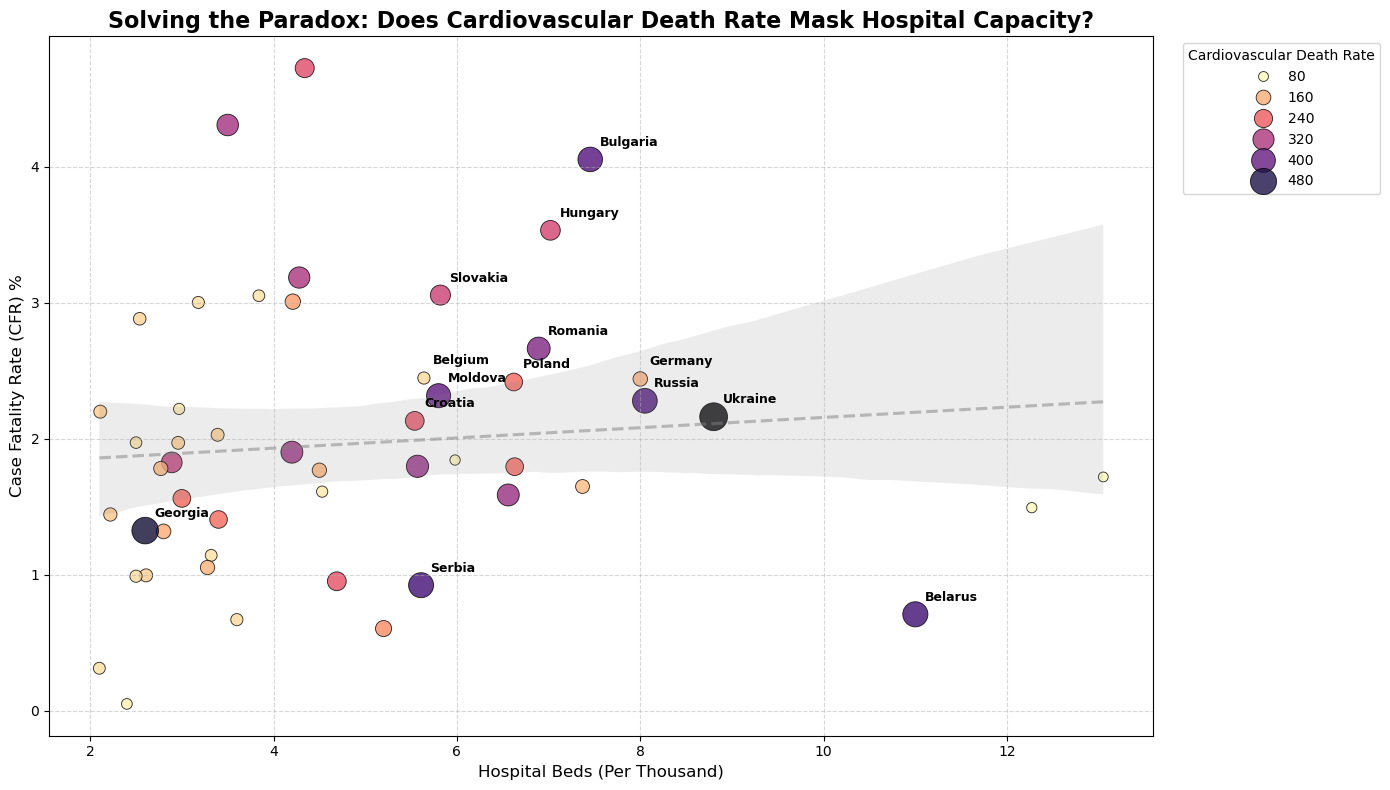

--- Statistical Evidence (Older Countries Only) ---
Correlation (Hospital Beds vs. CFR): 0.10
Correlation (Cardiovascular Death Rate vs. CFR): 0.23


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Önce hangi sütunu kullanacağımıza karar verelim
if 'cardiovasc_death_rate' in df.columns:
    health_col = 'cardiovasc_death_rate'
    label_text = 'Cardiovascular Death Rate'
elif 'diabetes_prevalence' in df.columns:
    health_col = 'diabetes_prevalence'
    label_text = 'Diabetes Prevalence (%)'
else:
    print("HATA: Ne Kalp ne de Diyabet verisi bulundu. Grafik çizilemiyor.")
    health_col = None

if health_col:
    # 1. Prepare Data
    df_anomaly = df_latest[
        (df_latest['median_age'] > 35) & 
        (df_latest['cfr'] < 10) &
        (df_latest['population'] > 1_000_000)
    ].copy()

    # 2. SETUP THE CHART
    plt.figure(figsize=(14, 8))

    # Scatter Plot
    scatter = sns.scatterplot(
        data=df_anomaly,
        x='hospital_beds_per_thousand',
        y='cfr',
        hue=health_col,      # DÜZELTİLDİ
        size=health_col,     # DÜZELTİLDİ
        sizes=(50, 400),
        palette='magma_r',
        alpha=0.8,
        edgecolor='black'
    )

    # Trend Line
    sns.regplot(
        data=df_anomaly, x='hospital_beds_per_thousand', y='cfr', 
        scatter=False, line_kws={'color': 'gray', 'linestyle': '--', 'alpha': 0.5}
    )

    # 3. ANNOTATIONS
    for i in range(df_anomaly.shape[0]):
        row = df_anomaly.iloc[i]
        # Etiketleme kuralı (Değerler sütuna göre değişebilir, genel bir filtre yapıyoruz)
        val = row[health_col]
        if (row['hospital_beds_per_thousand'] > 4.5 and row['cfr'] > 2.0) or (val > df_anomaly[health_col].quantile(0.90)):
            plt.text(
                row['hospital_beds_per_thousand'] + 0.1, 
                row['cfr'] + 0.1, 
                row['location'], 
                fontsize=9, 
                fontweight='bold', 
                color='black'
            )

    # 4. ENGLISH LABELS
    plt.title(f'Solving the Paradox: Does {label_text} Mask Hospital Capacity?', fontsize=16, fontweight='bold')
    plt.xlabel('Hospital Beds (Per Thousand)', fontsize=12)
    plt.ylabel('Case Fatality Rate (CFR) %', fontsize=12)

    plt.legend(title=label_text, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.show()

    # 5. STATISTICAL PROOF
    corr_beds = df_anomaly['hospital_beds_per_thousand'].corr(df_anomaly['cfr'])
    corr_health = df_anomaly[health_col].corr(df_anomaly['cfr'])

    print(f"--- Statistical Evidence (Older Countries Only) ---")
    print(f"Correlation (Hospital Beds vs. CFR): {corr_beds:.2f}")
    print(f"Correlation ({label_text} vs. CFR): {corr_health:.2f}")

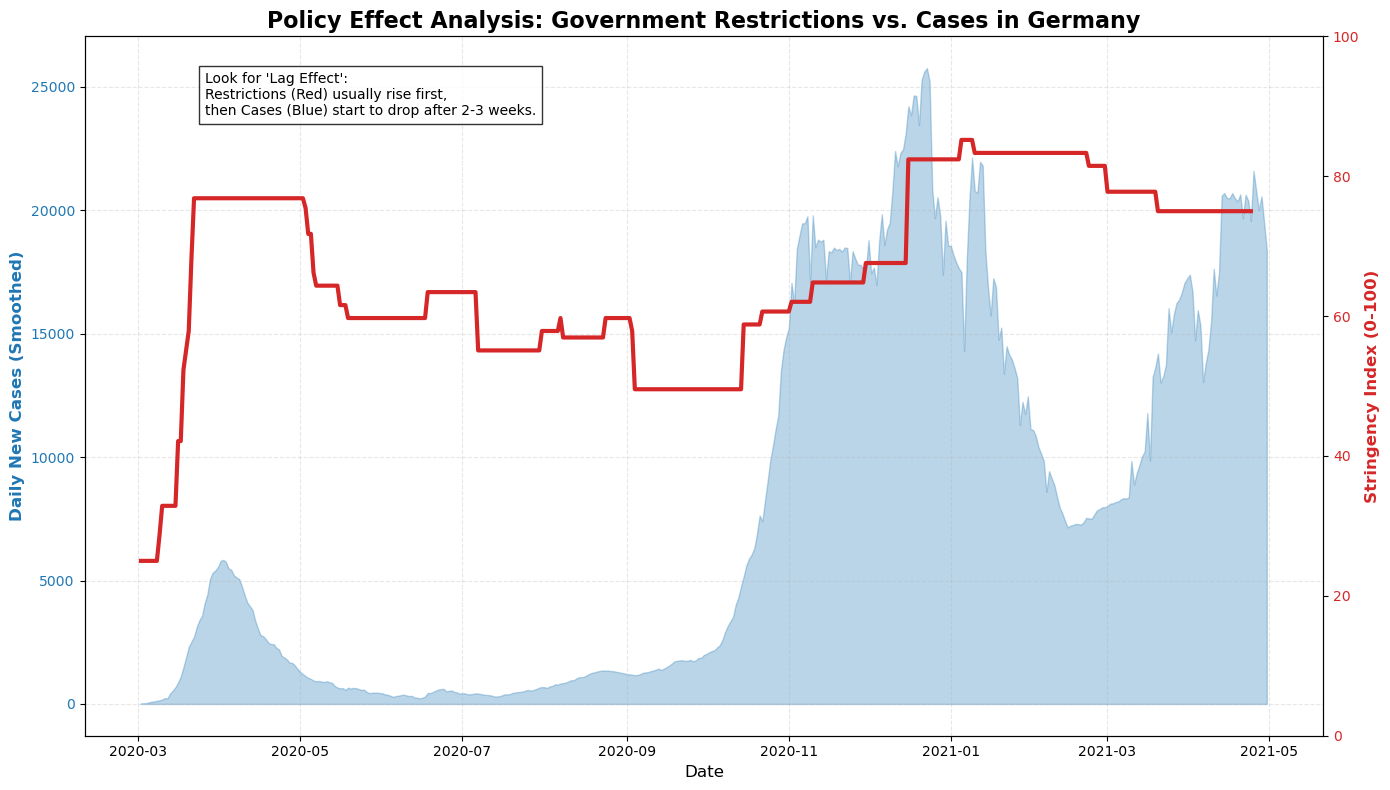

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- AYARLAR ---
ulke_secimi = 'Germany'  # 'Turkey', 'France', 'United Kingdom', 'Italy' yazabilirsin
start_date = '2020-03-01' # Pandemi başlangıcı

# 1. Veriyi Hazırla
df_country = df[
    (df['location'] == ulke_secimi) & 
    (df['date'] > start_date)
].sort_values('date').copy()

# 2. Grafik Çerçevesi (Dual Axis)
fig, ax1 = plt.subplots(figsize=(14, 8))

# --- SOL EKSEN: VAKALAR (Mavi Alan) ---
color_cases = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daily New Cases (Smoothed)', color=color_cases, fontsize=12, fontweight='bold')
ax1.fill_between(df_country['date'], df_country['new_cases_smoothed'], color=color_cases, alpha=0.3, label='New Cases')
ax1.tick_params(axis='y', labelcolor=color_cases)
ax1.grid(True, linestyle='--', alpha=0.3)

# --- SAĞ EKSEN: YASAKLAR (Kırmızı Çizgi) ---
# Aynı X eksenini paylaşan ikinci bir eksen yaratıyoruz
ax2 = ax1.twinx() 
color_stringency = 'tab:red'
ax2.set_ylabel('Stringency Index (0-100)', color=color_stringency, fontsize=12, fontweight='bold')
ax2.plot(df_country['date'], df_country['stringency_index'], color=color_stringency, linewidth=3, linestyle='-', label='Stringency Index')
ax2.tick_params(axis='y', labelcolor=color_stringency)
ax2.set_ylim(0, 100) # İndeks her zaman 0-100 arasındadır

# --- DETAYLAR ---
plt.title(f'Policy Effect Analysis: Government Restrictions vs. Cases in {ulke_secimi}', fontsize=16, fontweight='bold')

# Açıklayıcı bir not ekleyelim
plt.figtext(0.15, 0.85, 
            "Look for 'Lag Effect':\nRestrictions (Red) usually rise first,\nthen Cases (Blue) start to drop after 2-3 weeks.", 
            fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

fig.tight_layout()
plt.show()

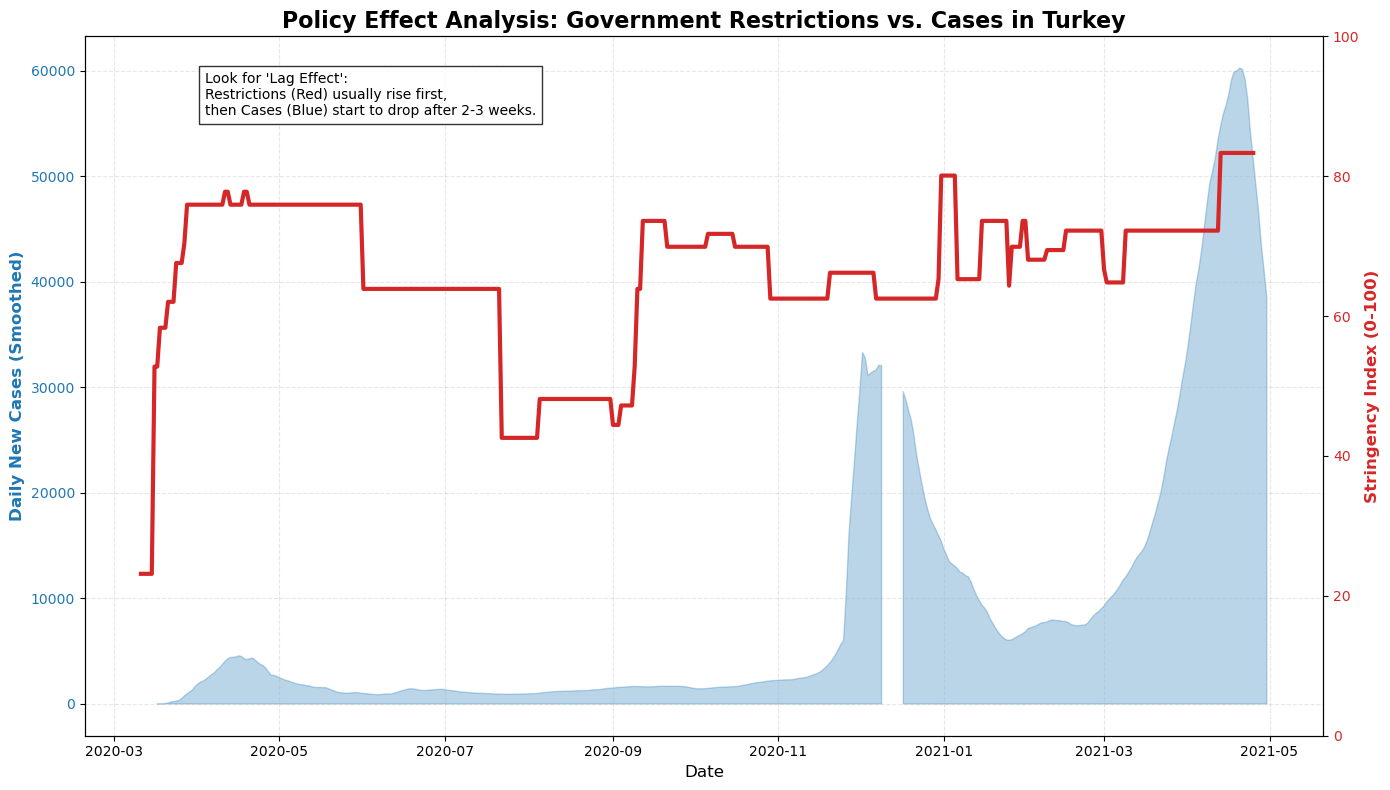

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- AYARLAR ---
ulke_secimi = 'Turkey'  # Buraya 'Turkey', 'France', 'United Kingdom', 'Italy', 'Germany' yazabilirsin
start_date = '2020-03-01' # Pandemi başlangıcı

# 1. Veriyi Hazırla
df_country = df[
    (df['location'] == ulke_secimi) & 
    (df['date'] > start_date)
].sort_values('date').copy()

# 2. Grafik Çerçevesi (Dual Axis)
fig, ax1 = plt.subplots(figsize=(14, 8))

# --- SOL EKSEN: VAKALAR (Mavi Alan) ---
color_cases = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daily New Cases (Smoothed)', color=color_cases, fontsize=12, fontweight='bold')
ax1.fill_between(df_country['date'], df_country['new_cases_smoothed'], color=color_cases, alpha=0.3, label='New Cases')
ax1.tick_params(axis='y', labelcolor=color_cases)
ax1.grid(True, linestyle='--', alpha=0.3)

# --- SAĞ EKSEN: YASAKLAR (Kırmızı Çizgi) ---
# Aynı X eksenini paylaşan ikinci bir eksen yaratıyoruz
ax2 = ax1.twinx() 
color_stringency = 'tab:red'
ax2.set_ylabel('Stringency Index (0-100)', color=color_stringency, fontsize=12, fontweight='bold')
ax2.plot(df_country['date'], df_country['stringency_index'], color=color_stringency, linewidth=3, linestyle='-', label='Stringency Index')
ax2.tick_params(axis='y', labelcolor=color_stringency)
ax2.set_ylim(0, 100) # İndeks her zaman 0-100 arasındadır

# --- DETAYLAR ---
plt.title(f'Policy Effect Analysis: Government Restrictions vs. Cases in {ulke_secimi}', fontsize=16, fontweight='bold')

# Açıklayıcı bir not ekleyelim
plt.figtext(0.15, 0.85, 
            "Look for 'Lag Effect':\nRestrictions (Red) usually rise first,\nthen Cases (Blue) start to drop after 2-3 weeks.", 
            fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

fig.tight_layout()
plt.show()